In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from pathlib import Path
import json
from datetime import datetime
import time

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - bl[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    padding = 10
    maxWidth += padding * 2
    maxHeight += padding * 2
    dst = np.array([[padding, padding],[maxWidth - padding, padding],[maxWidth - padding, maxHeight - padding],[padding, maxHeight - padding]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def enhance_paper_edges(gray):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    blur1 = cv2.GaussianBlur(enhanced, (3, 3), 0)
    blur2 = cv2.GaussianBlur(enhanced, (7, 7), 0)
    blur3 = cv2.GaussianBlur(enhanced, (5, 5), 0)
    edges_list = []
    edges1 = cv2.Canny(blur1, 20, 80)
    edges2 = cv2.Canny(blur1, 40, 120)
    edges3 = cv2.Canny(blur2, 30, 100)
    edges4 = cv2.Canny(blur3, 25, 90)
    edges5 = cv2.Canny(blur1, 50, 150)
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_medium = np.ones((5, 5), np.uint8)
    kernel_large = np.ones((7, 7), np.uint8)
    edges1_dilated = cv2.dilate(edges1, kernel_large, iterations=2)
    edges2_dilated = cv2.dilate(edges2, kernel_large, iterations=2)
    edges3_dilated = cv2.dilate(edges3, kernel_medium, iterations=2)
    edges4_dilated = cv2.dilate(edges4, kernel_medium, iterations=3)
    edges5_dilated = cv2.dilate(edges5, kernel_small, iterations=2)
    edges_list.extend([edges1_dilated, edges2_dilated, edges3_dilated, edges4_dilated, edges5_dilated])
    _, thresh1 = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh2 = cv2.threshold(enhanced, 150, 255, cv2.THRESH_BINARY)
    _, thresh3 = cv2.threshold(enhanced, 180, 255, cv2.THRESH_BINARY)
    thresh4 = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    kernel_close = np.ones((15, 15), np.uint8)
    thresh1_closed = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel_close)
    thresh2_closed = cv2.morphologyEx(thresh2, cv2.MORPH_CLOSE, kernel_close)
    thresh3_closed = cv2.morphologyEx(thresh3, cv2.MORPH_CLOSE, kernel_close)
    thresh4_closed = cv2.morphologyEx(thresh4, cv2.MORPH_CLOSE, kernel_close)
    edges6 = cv2.Canny(thresh1_closed, 50, 150)
    edges7 = cv2.Canny(thresh2_closed, 50, 150)
    edges8 = cv2.Canny(thresh3_closed, 50, 150)
    edges9 = cv2.Canny(thresh4_closed, 50, 150)
    edges_list.extend([edges6, edges7, edges8, edges9])
    sobelx = cv2.Sobel(blur1, cv2.CV_64F, 1, 0, ksize=5)
    sobelx = np.abs(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobelx_thresh = cv2.threshold(sobelx, 50, 255, cv2.THRESH_BINARY)
    edges10 = cv2.dilate(sobelx_thresh, kernel_medium, iterations=2)
    edges_list.append(edges10)
    combined = np.zeros_like(edges1)
    for edge in edges_list:
        combined = cv2.bitwise_or(combined, edge)
    kernel = np.ones((3, 3), np.uint8)
    combined = cv2.dilate(combined, kernel, iterations=1)
    return combined, edges_list

def find_best_quadrilateral(edges, w, h):
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    min_area = (w * h) * 0.08
    max_area = (w * h) * 0.85
    candidates = []
    for c in contours:
        area = cv2.contourArea(c)
        if area < min_area or area > max_area:
            continue
        peri = cv2.arcLength(c, True)
        epsilon_values = list(np.arange(0.008, 0.025, 0.002)) + list(np.arange(0.025, 0.08, 0.005))
        for epsilon in epsilon_values:
            approx = cv2.approxPolyDP(c, epsilon * peri, True)
            if len(approx) == 4:
                rect = cv2.minAreaRect(c)
                box_w, box_h = rect[1]
                if box_w == 0 or box_h == 0:
                    continue
                aspect_ratio = max(box_w, box_h) / min(box_w, box_h)
                if aspect_ratio > 4.0:
                    continue
                hull = cv2.convexHull(c)
                hull_area = cv2.contourArea(hull)
                rectangularity = area / hull_area if hull_area > 0 else 0
                if rectangularity < 0.65:
                    continue
                pts = approx.reshape(4, 2)
                angles = []
                for i in range(4):
                    p1 = pts[i]
                    p2 = pts[(i + 1) % 4]
                    p3 = pts[(i + 2) % 4]
                    v1 = p1 - p2
                    v2 = p3 - p2
                    dot = np.dot(v1, v2)
                    norms = np.linalg.norm(v1) * np.linalg.norm(v2)
                    if norms == 0:
                        continue
                    cos_angle = np.clip(dot / norms, -1, 1)
                    angle = np.arccos(cos_angle)
                    angles.append(np.abs(angle - np.pi/2))
                if not angles:
                    continue
                avg_angle_dev = np.mean(angles)
                angle_score = 1.0 / (1.0 + avg_angle_dev * 1.8)
                if angle_score < 0.20:
                    continue
                M = cv2.moments(c)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    center_dist = np.sqrt((cx - w/2)**2 + (cy - h/2)**2)
                    max_dist = np.sqrt((w/2)**2 + (h/2)**2)
                    center_score = 1.0 - (center_dist / max_dist) * 0.25
                else:
                    center_score = 0.5
                pts_flat = approx.reshape(-1, 2)
                margin = min(w, h) * 0.03
                touches_left = np.any(pts_flat[:, 0] < margin)
                touches_right = np.any(pts_flat[:, 0] > w - margin)
                touches_top = np.any(pts_flat[:, 1] < margin)
                touches_bottom = np.any(pts_flat[:, 1] > h - margin)
                edge_count = sum([touches_left, touches_right, touches_top, touches_bottom])
                if edge_count == 4:
                    continue
                elif edge_count == 3:
                    edge_penalty = 0.2
                elif edge_count == 2:
                    edge_penalty = 0.65
                elif edge_count == 1:
                    edge_penalty = 0.95
                else:
                    edge_penalty = 1.0
                area_ratio = area / (w * h)
                if area_ratio > 0.78:
                    continue
                left_edge_bonus = 1.0
                if edge_count == 1 and touches_left:
                    left_edge_bonus = 1.15
                score = (area ** 0.9) * (rectangularity ** 1.4) * (angle_score ** 1.1) * (center_score ** 0.6) * (edge_penalty ** 1.8) * left_edge_bonus
                candidates.append({'contour': approx,'area': area,'aspect_ratio': aspect_ratio,'rectangularity': rectangularity,'angle_score': angle_score,'center_score': center_score,'edge_penalty': edge_penalty,'edge_count': edge_count,'score': score,'epsilon': epsilon})
    if not candidates:
        return None
    candidates.sort(key=lambda x: x['score'], reverse=True)
    return candidates[0]

def detect_paper_ultra_robust(image_path, debug=True):
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        img_name = image_path
    else:
        image = image_path
        img_name = "array"
    orig = image.copy()
    h, w = image.shape[:2]
    print(f"\n{'='*60}")
    print(f"Processing: {img_name}")
    print(f"Image size: {w}x{h}")
    print(f"{'='*60}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    combined_edges, edge_list = enhance_paper_edges(gray)
    best = find_best_quadrilateral(combined_edges, w, h)
    if best:
        print(f"\n✓ Found 4-point contour!")
        print(f"  Area: {best['area']:.0f} ({best['area']/(w*h)*100:.1f}% of image)")
        print(f"  Aspect ratio: {best['aspect_ratio']:.2f}")
        print(f"  Rectangularity: {best['rectangularity']:.3f}")
        print(f"  Angle score: {best['angle_score']:.3f}")
        print(f"  Center score: {best['center_score']:.3f}")
        print(f"  Edge penalty: {best['edge_penalty']:.3f}")
        print(f"  Edges touched: {best['edge_count']}")
        screenCnt = best['contour']
    else:
        print("\n⚠ No contour from combined edges, trying individual strategies...")
        for idx, edges in enumerate(edge_list):
            best = find_best_quadrilateral(edges, w, h)
            if best:
                print(f"✓ Found contour from strategy {idx+1}")
                screenCnt = best['contour']
                break
        else:
            print("\n❌ No 4-point contours found!")
            print("   Using largest contour bounding box...")
            contours, _ = cv2.findContours(combined_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest = max(contours, key=cv2.contourArea)
                x, y, w_rect, h_rect = cvcv2.boundingRect(largest)
                margin = 15
                x = max(0, x - margin)
                y = max(0, y - margin)
                w_rect = min(w - x, w_rect + 2*margin)
                h_rect = min(h - y, h_rect + 2*margin)
                screenCnt = np.array([[[x, y]],[[x + w_rect, y]],[[x + w_rect, y + h_rect]],[[x, y + h_rect]]], dtype=np.int32)
            else:
                margin = 30
                screenCnt = np.array([[[margin, margin]],[[w - margin, margin]],[[w - margin, h - margin]],[[margin, h - margin]]], dtype=np.int32)
    debug_img = orig.copy()
    cv2.drawContours(debug_img, [screenCnt], -1, (0, 255, 0), 5)
    pts = screenCnt.reshape(4, 2)
    ordered = order_points(pts)
    labels = ['TL', 'TR', 'BR', 'BL']
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    for point, label, color in zip(ordered, labels, colors):
        pt = tuple(point.astype(int))
        cv2.circle(debug_img, pt, 15, color, -1)
        cv2.putText(debug_img, label, (pt[0]+20, pt[1]+20), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)
    warped = four_point_transform(orig, screenCnt.reshape(4, 2))
    wh, ww = warped.shape[:2]
    if ww > wh:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        print("↻ Auto-rotated to portrait")
    if debug:
        return orig, debug_img, combined_edges, warped
    return warped

In [ ]:
def detect_paper_orientation_robust(image):
    h, w = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    top_half = gray[0:h//2, :]
    bottom_half = gray[h//2:h, :]

    _, top_binary = cv2.threshold(top_half, 200, 255, cv2.THRESH_BINARY_INV)
    _, bottom_binary = cv2.threshold(bottom_half, 200, 255, cv2.THRESH_BINARY_INV)

    top_content = np.sum(top_binary > 0)
    bottom_content = np.sum(bottom_binary > 0)

    print(f"   Content density: Top={top_content}, Bottom={bottom_content}")

    edges = cv2.Canny(gray, 50, 150)

    third = h // 3
    top_third = edges[0:third, :]
    bottom_third = edges[2*third:h, :]

    top_edges = np.sum(top_third > 0)
    bottom_edges = np.sum(bottom_third > 0)

    print(f"   Edge density: Top={top_edges}, Bottom={bottom_edges}")

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    top_bubbles = 0
    bottom_bubbles = 0

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 80 < area < 2500:
            perimeter = cv2.arcLength(cnt, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.3:
                    M = cv2.moments(cnt)
                    if M["m00"] != 0:
                        cy = int(M["m01"] / M["m00"])
                        if cy < h // 2:
                            top_bubbles += 1
                        else:
                            bottom_bubbles += 1

    print(f"   Bubble distribution: Top={top_bubbles}, Bottom={bottom_bubbles}")

    votes_for_upside_down = 0
    votes_for_correct = 0

    if bottom_content > top_content * 1.2:
        votes_for_correct += 1
    elif top_content > bottom_content * 1.2:
        votes_for_upside_down += 1

    if top_bubbles > bottom_bubbles * 1.3:
        votes_for_correct += 1
    elif bottom_bubbles > top_bubbles * 1.3:
        votes_for_upside_down += 1

    if bottom_edges > top_edges * 1.1:
        votes_for_correct += 1
    elif top_edges > bottom_edges * 1.1:
        votes_for_upside_down += 1

    print(f"   Voting: Correct={votes_for_correct}, Upside-down={votes_for_upside_down}")

    if votes_for_upside_down > votes_for_correct:
        print("   ⚠️  Paper detected as UPSIDE DOWN - rotating 180°")
        return 180
    else:
        print("   ✓ Paper orientation appears correct")
        return 0


def correct_paper_orientation(image):
    rotation_needed = detect_paper_orientation_robust(image)

    if rotation_needed == 180:
        corrected = cv2.rotate(image, cv2.ROTATE_180)
        return corrected, True
    else:
        return image, False

def detect_orientation_by_text(image):
    h, w = image.shape[:2]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    top_region = gray[0:int(h*0.2), :]
    bottom_region = gray[int(h*0.8):h, :]

    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))

    top_horizontal = cv2.morphologyEx(top_region, cv2.MORPH_OPEN, kernel_horizontal)
    bottom_horizontal = cv2.morphologyEx(bottom_region, cv2.MORPH_OPEN, kernel_horizontal)

    top_lines = np.sum(top_horizontal > 0)
    bottom_lines = np.sum(bottom_horizontal > 0)

    print(f"   Horizontal structure: Top={top_lines}, Bottom={bottom_lines}")

    if bottom_lines > top_lines * 2:
        print("   ⚠️  Title appears at bottom - rotating 180°")
        return 180
    else:
        print("   ✓ Title appears at top - orientation correct")
        return 0

In [ ]:
def detect_question_region(image):
    h, w = image.shape[:2]
    crop_y1 = int(h * 0.08)
    crop_y2 = int(h * 0.98)
    crop_x1 = int(w * 0.05)
    crop_x2 = int(w * 0.65)
    question_region = image[crop_y1:crop_y2, crop_x1:crop_x2]
    return question_region, (crop_x1, crop_y1, crop_x2, crop_y2)

def detect_bubbles_simple(image, min_area=80, max_area=2500):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []
    seen_positions = set()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area or area > max_area:
            continue

        x, y, w, h = cv2.boundingRect(cnt)

        aspect_ratio = float(w) / h if h > 0 else 0
        if aspect_ratio < 0.4 or aspect_ratio > 2.0:
            continue

        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity < 0.3:
            continue

        cx = x + w // 2
        cy = y + h // 2

        position_key = (cx // 10, cy // 10)
        if position_key in seen_positions:
            continue
        seen_positions.add(position_key)

        roi = gray[y:y+h, x:x+w]
        mean_intensity = np.mean(roi)

        margin = max(1, min(w, h) // 4)
        if y+margin < y+h-margin and x+margin < x+w-margin:
            interior = gray[y+margin:y+h-margin, x+margin:x+w-margin]
            interior_intensity = np.mean(interior) if interior.size > 0 else mean_intensity
        else:
            interior_intensity = mean_intensity

        bubbles.append({
            'x': x, 'y': y, 'w': w, 'h': h,
            'cx': cx, 'cy': cy,
            'area': area,
            'intensity': interior_intensity,
            'mean_intensity': mean_intensity
        })

    return bubbles, gray

def extract_answers_robust(bubbles, q_num=None, is_problematic=False):
    if len(bubbles) < 5:
        return bubbles

    if len(bubbles) == 5:
        return bubbles

    x_positions = [b['cx'] for b in bubbles]

    for i in range(1, min(4, len(x_positions))):
        gap = x_positions[i] - x_positions[i-1]

        if gap > 20:
            answer_bubbles = bubbles[i:i+5]
            if len(answer_bubbles) == 5:
                spacings = [answer_bubbles[j+1]['cx'] - answer_bubbles[j]['cx']
                           for j in range(4)]
                avg_spacing = np.mean(spacings)
                if all(abs(s - avg_spacing) < avg_spacing * 0.5 for s in spacings):
                    return answer_bubbles

    best_candidate = None
    best_uniformity = float('inf')
    best_start_idx = -1

    if len(bubbles) >= 6:
        for start_idx in range(len(bubbles) - 4):
            candidate = bubbles[start_idx:start_idx+5]
            if len(candidate) == 5:
                spacings = [candidate[j+1]['cx'] - candidate[j]['cx'] for j in range(4)]
                std_spacing = np.std(spacings)

                if std_spacing < best_uniformity:
                    best_uniformity = std_spacing
                    best_candidate = candidate
                    best_start_idx = start_idx

        if best_candidate and best_uniformity < 10:
            return best_candidate

    if len(bubbles) >= 6:
        areas = [b['area'] for b in bubbles]
        if areas[0] < np.mean(areas[1:6]) * 0.8:
            return bubbles[1:6]

    if len(bubbles) == 6:
        return bubbles[1:6]

    if len(bubbles) >= 6:
        return bubbles[1:6]


    return bubbles[:5]

def organize_bubbles_by_grid_fixed(bubbles):
    if len(bubbles) < 50:
        print(f"   WARNING: Only {len(bubbles)} bubbles detected")

    bubbles_sorted = sorted(bubbles, key=lambda b: b['cy'])

    avg_height = np.mean([b['h'] for b in bubbles_sorted])
    y_threshold = max(18, avg_height * 0.75)

    print(f"   Using Y-threshold: {y_threshold:.1f} pixels (avg bubble height: {avg_height:.1f})")

    rows = []
    current_row = [bubbles_sorted[0]]

    for bubble in bubbles_sorted[1:]:
        min_diff = min(abs(bubble['cy'] - b['cy']) for b in current_row)

        if min_diff < y_threshold:
            current_row.append(bubble)
        else:
            if len(current_row) >= 4:
                rows.append(sorted(current_row, key=lambda b: b['cx']))
            elif len(current_row) >= 2:
                rows.append(sorted(current_row, key=lambda b: b['cx']))
            current_row = [bubble]

    if len(current_row) >= 4:
        rows.append(sorted(current_row, key=lambda b: b['cx']))
    elif len(current_row) >= 2:
        rows.append(sorted(current_row, key=lambda b: b['cx']))

    print(f"   Found {len(rows)} rows with bubbles")

    questions = {}
    problematic_rows = []

    for row_idx, row_bubbles in enumerate(rows):
        if row_idx >= 25:
            break

        num_bubbles = len(row_bubbles)

        if num_bubbles < 6:
            continue

        if num_bubbles < 10:
            problematic_rows.append(row_idx)

        x_positions = [b['cx'] for b in row_bubbles]

        gaps = []
        for i in range(1, len(x_positions)):
            gap = x_positions[i] - x_positions[i-1]
            gaps.append((gap, i))

        if not gaps:
            continue

        gaps.sort(reverse=True)
        main_split_idx = gaps[0][1]

        left_group = row_bubbles[:main_split_idx]
        right_group = row_bubbles[main_split_idx:]

        if num_bubbles == 10:
            if len(left_group) == 5 and len(right_group) == 5:
                questions[row_idx + 1] = left_group
                questions[row_idx + 26] = right_group
                continue

        q_left = row_idx + 1
        left_answers = extract_answers_robust(left_group, q_num=q_left, is_problematic=row_idx in problematic_rows)
        if left_answers and len(left_answers) == 5:
            questions[q_left] = left_answers
        elif left_answers and len(left_answers) >= 3:
            while len(left_answers) < 5:
                left_answers.append(None)
            questions[q_left] = left_answers

        q_right = row_idx + 26
        right_answers = extract_answers_robust(right_group, q_num=q_right, is_problematic=row_idx in problematic_rows)
        if right_answers and len(right_answers) == 5:
            questions[q_right] = right_answers
        elif right_answers and len(right_answers) >= 3:
            while len(right_answers) < 5:
                right_answers.append(None)
            questions[q_right] = right_answers


    print(f"   Successfully organized {len(questions)}/50 questions")
    return questions

def detect_filled_bubble_fixed(bubbles):
    if not bubbles or len(bubbles) < 2:
        return None, 0

    valid_bubbles = [b for b in bubbles if b is not None]
    if len(valid_bubbles) < 2:
        return None, 0

    intensities = np.array([b['intensity'] for b in valid_bubbles])

    min_idx = int(np.argmin(intensities))
    min_intensity = float(intensities[min_idx])

    sorted_intensities = np.sort(intensities)
    second_min_intensity = float(sorted_intensities[1]) if len(sorted_intensities) > 1 else min_intensity

    avg_all = np.mean(intensities)
    std_all = np.std(intensities)
    contrast = second_min_intensity - min_intensity

    if avg_all > 210 and std_all < 1.5:
        return None, 0

    if min_intensity < 180:
        return min_idx, 0.9

    if min_intensity < 195 and contrast >= 5:
        return min_idx, 0.85

    if min_intensity < 200 and contrast >= 3:
        return min_idx, 0.8

    if min_intensity < 208 and contrast >= 2:
        return min_idx, 0.6

    if min_intensity < 212 and contrast >= 1.5:
        return min_idx, 0.4

    if contrast >= 1.0 and min_intensity < 215:
        if min_intensity < avg_all - 0.5:
            return min_idx, 0.2

    return None, 0


    return None, 0

def analyze_all_answers(questions, debug_suspicious=True):
    labels = ['A', 'B', 'C', 'D', 'E']
    answers = {}
    suspicious = []

    for q_num in sorted(questions.keys()):
        bubbles = questions[q_num]

        if len(bubbles) != 5:
            if len(bubbles) < 5:
                bubbles = bubbles + [None] * (5 - len(bubbles))
            else:
                bubbles = bubbles[:5]

        valid_bubbles = [b for b in bubbles if b is not None]

        if not valid_bubbles:
            answers[q_num] = None
            continue

        idx, confidence = detect_filled_bubble_fixed(valid_bubbles)

        if idx is not None and 0 <= idx < len(valid_bubbles):
            answer_label = None
            for i in range(5):
                if i < len(bubbles) and bubbles[i] == valid_bubbles[idx]:
                    answer_label = labels[i]
                    break
            answers[q_num] = answer_label

            if len(valid_bubbles) >= 2:
                intensities = [b['intensity'] for b in valid_bubbles]
                min_int = min(intensities)
                sorted_ints = sorted(intensities)
                if len(sorted_ints) >= 2:
                    contrast = sorted_ints[1] - sorted_ints[0]
                    if contrast < 5 and min_int > 130:
                        suspicious.append((q_num, answer_label, intensities, contrast))
        else:
            answers[q_num] = None


    if debug_suspicious and suspicious:
        print(f"\n   ⚠️  SUSPICIOUS DETECTIONS (very close intensities):")
        for q_num, ans, intensities, contrast in suspicious:
            int_str = ', '.join([f"{labels[i]}={int(intensities[i])}" for i in range(len(intensities))])
            print(f"      Q{q_num}: Detected {ans}, contrast={contrast:.1f}, [{int_str}]")

    return answers

In [ ]:
def detect_variant_region(image):
    h, w = image.shape[:2]
    y_start = int(h * 0.06)
    y_end = int(h * 0.22)
    x_start = int(w * 0.60)
    x_end = int(w * 0.92)
    variant_region = image[y_start:y_end, x_start:x_end]
    return variant_region, (x_start, y_start, x_end, y_end)
def detect_variant(image):
    variant_region, bounds = detect_variant_region(image)
    if variant_region is None:
        return None, [], 0.0

    gray = cv2.cvtColor(variant_region, cv2.COLOR_BGR2GRAY)
    h, w = variant_region.shape[:2]

    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []

    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area < 200 or area > 2000:
            continue

        x, y, bw, bh = cv2.boundingRect(cnt)

        aspect_ratio = float(bw) / bh if bh > 0 else 0
        if aspect_ratio < 0.5 or aspect_ratio > 2.0:
            continue

        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity < 0.4:
            continue

        cx = x + bw // 2
        cy = y + bh // 2

        margin = max(2, min(bw, bh) // 4)
        y1, y2 = y + margin, y + bh - margin
        x1, x2 = x + margin, x + bw - margin

        if y2 > y1 and x2 > x1:
            interior = gray[y1:y2, x1:x2]
            interior_intensity = np.mean(interior) if interior.size > 0 else 255
        else:
            roi = gray[y:y+bh, x:x+bw]
            interior_intensity = np.mean(roi) if roi.size > 0 else 255

        bubbles.append({
            'x': x, 'y': y, 'w': bw, 'h': bh,
            'cx': cx, 'cy': cy,
            'area': area,
            'intensity': interior_intensity,
            'circularity': circularity
        })

    if len(bubbles) == 0:
        print(f"   WARNING: No variant bubbles detected")
        return None, [], 0.0

    bubbles.sort(key=lambda b: b['cx'])

    if len(bubbles) > 1:
        y_positions = [b['cy'] for b in bubbles]
        y_median = np.median(y_positions)
        y_threshold = h * 0.3

        aligned_bubbles = [b for b in bubbles if abs(b['cy'] - y_median) < y_threshold]

        if len(aligned_bubbles) >= 3:
            bubbles = aligned_bubbles

    if len(bubbles) < 3:
        print(f"   WARNING: Found only {len(bubbles)} bubbles")
        return None, bubbles, 0.0

    bubbles = bubbles[:5]

    labels = ['A', 'B', 'C', 'D', 'E']

    intensities = [b['intensity'] for b in bubbles]
    min_intensity = min(intensities)
    min_idx = intensities.index(min_intensity)

    avg_intensity = np.mean(intensities)
    contrast = (avg_intensity - min_intensity) / avg_intensity if avg_intensity > 0 else 0

    print(f"   Variant scores: {[f'{int(x)}' for x in intensities]}")
    print(f"   Min: {min_intensity:.0f}, Avg: {avg_intensity:.0f}, Contrast: {contrast:.2%}")

    if contrast > 0.08:
        detected_variant = labels[min_idx]
        confidence = min(0.98, contrast * 10)

        print(f"   Variant {detected_variant}: intensity={min_intensity:.0f}, contrast={contrast:.2%}, conf={confidence:.2f}")
        return detected_variant, bubbles, confidence

    print(f"   WARNING: Insufficient contrast ({contrast:.2%})")
    return None, bubbles, 0.0

def visualize_variant_detection(image, variant_region, variant, bubbles, confidence, output_path=None):
    if isinstance(variant_region, str) and isinstance(variant, list):
        old_variant = variant_region
        old_bubbles = variant
        old_confidence = bubbles
        old_output = confidence

        variant = old_variant
        bubbles = old_bubbles
        try:
            confidence = float(old_confidence)
        except Exception:
            confidence = 0.0
        output_path = old_output
        variant_region = None

    if variant_region is None:
        try:
            variant_region, _ = detect_variant_region(image)
        except Exception:
            variant_region = image.copy()

    vis_full = image.copy()
    vis_variant = variant_region.copy()

    variants = ['A', 'B', 'C', 'D', 'E']

    for idx, bubble in enumerate(bubbles[:5]):
        label = variants[idx] if idx < len(variants) else '?'

        if label == variant:
            color = (0, 255, 0)
            thickness = 4
        else:
            color = (180, 180, 180)
            thickness = 1

        cv2.circle(vis_variant, (bubble['cx'], bubble['cy']),
                   bubble['w']//2, color, thickness)

        intensity = int(bubble.get('intensity', 0))
        cv2.putText(vis_variant, str(intensity),
                   (bubble['cx']-15, bubble['cy']+5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

        cv2.putText(vis_variant, label,
                   (bubble['cx']-8, bubble['cy']-bubble['h']//2-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    variant_text = f"Variant: {variant or '?'} (conf: {confidence:.2f})"
    cv2.putText(vis_variant, variant_text, (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7,
               (0, 255, 0) if variant else (0, 0, 255), 2)

    h, w = image.shape[:2]
    y_start = int(h * 0.08)
    y_end = int(h * 0.20)
    x_start = int(w * 0.55)
    x_end = int(w * 0.96)
    cv2.rectangle(vis_full, (x_start, y_start), (x_end, y_end), (0, 255, 255), 3)

    cv2.putText(vis_full, f"Variant: {variant or '?'}",
               (x_start, y_start - 10),
               cv2.FONT_HERSHEY_SIMPLEX, 1.0,
               (0, 255, 0) if variant else (0, 0, 255), 2)

    if output_path is not None:
        try:
            out_p = Path(output_path)
            out_p.parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(out_p), vis_variant)
        except Exception as e:
            print(f"Failed to save variant visualization to {output_path}: {e}")

    return vis_full, vis_variant

In [ ]:
def visualize_detection_simple(image, questions, answers, output_path):
    q_region, _ = detect_question_region(image)
    vis = q_region.copy() if len(q_region.shape) == 3 else cv2.cvtColor(q_region, cv2.COLOR_GRAY2BGR)

    labels = ['A', 'B', 'C', 'D', 'E']

    for q_num in sorted(questions.keys()):
        bubbles = questions[q_num]
        detected_answer = answers.get(q_num)

        valid_bubbles = [b for b in bubbles if b is not None]
        if valid_bubbles:
            intensities = [b['intensity'] for b in valid_bubbles]
            contrast = max(intensities) - min(intensities)
        else:
            contrast = 0

        for idx, bubble in enumerate(bubbles[:5]):
            if bubble is None:
                continue

            label = labels[idx]
            intensity = int(bubble['intensity'])

            if label == detected_answer:
                color = (0, 255, 0)
                thickness = 4
            else:
                color = (180, 180, 180)
                thickness = 1

            cv2.circle(vis, (bubble['cx'], bubble['cy']), bubble['w']//2, color, thickness)
            cv2.putText(vis, str(intensity), (bubble['cx']-12, bubble['cy']+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)

        first_bubble = next((b for b in bubbles if b is not None), None)
        if first_bubble:
            ans_text = detected_answer if detected_answer else '?'
            text = f"Q{q_num}:{ans_text}"
            cv2.putText(vis, text,
                       (max(5, first_bubble['cx'] - 60), first_bubble['cy']+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 0), 2)

            if detected_answer is None and contrast > 0:
                cv2.putText(vis, f"c:{int(contrast)}",
                           (max(5, first_bubble['cx'] - 60), first_bubble['cy']+20),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 140, 255), 1)

    cv2.imwrite(str(output_path), vis)

    fig, ax = plt.subplots(1, 1, figsize=(12, 18))
    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    ax.imshow(vis_rgb)
    ax.set_title('OMR Detection (Green=Detected, Numbers=Intensity, Lower=Darker)',
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()

    output_path_png = str(output_path).replace('.png', '_detailed.png')
    plt.savefig(output_path_png, dpi=150, bbox_inches='tight')
    plt.close()
def create_master_comparison_grid(answer_key_image, answer_key_questions, answer_key_answers,
                                   student_images_data, output_folder='omr_results'):
    print("\n" + "="*70)
    print("CREATING MASTER COMPARISON GRID WITH GRADING")
    print("="*70)

    key_vis = visualize_answer_key_only(answer_key_image, answer_key_questions, answer_key_answers)

    student_visualizations = []
    student_names = []

    for student_data in student_images_data:
        student_name = student_data['name']
        student_image = student_data['image']
        student_questions = student_data['questions']
        student_answers = student_data['answers']

        vis = visualize_results_with_grading(student_image, student_questions,
                                            student_answers, answer_key_answers)
        student_visualizations.append(vis)
        student_names.append(student_name)

    fig, axes = plt.subplots(3, 4, figsize=(24, 20))
    axes = axes.flatten()

    key_rgb = cv2.cvtColor(key_vis, cv2.COLOR_BGR2RGB)
    axes[0].imshow(key_rgb)
    axes[0].set_title('ANSWER KEY', fontsize=16, fontweight='bold',
                     color='green', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[0].axis('off')

    for idx, (vis, name) in enumerate(zip(student_visualizations, student_names)):
        vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
        axes[idx + 1].imshow(vis_rgb)

        student_info = student_images_data[idx]
        score = student_info['correct']
        percentage = student_info['percentage']

        if percentage >= 70:
            title_color = 'green'
            bg_color = 'lightgreen'
        elif percentage >= 50:
            title_color = 'orange'
            bg_color = 'lightyellow'
        else:
            title_color = 'red'
            bg_color = 'lightcoral'

        score_text = f"{name}\n{score}/50 ({percentage:.1f}%)"
        axes[idx + 1].set_title(score_text, fontsize=14, fontweight='bold',
                               color=title_color,
                               bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.8))
        axes[idx + 1].axis('off')

    axes[11].axis('off')

    legend_text = "✓ = Correct (Green)  |  ✗ = Wrong (Red X)  |  ○ = Blank (Orange)"
    fig.text(0.5, 0.02, legend_text, ha='center', fontsize=14,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout(rect=[0, 0.03, 1, 1])

    output_path = Path(output_folder) / 'MASTER_COMPARISON_GRID.png'
    plt.savefig(output_path, dpi=200, bbox_inches='tight')
    print(f"✓ Saved master grid: {output_path}")

    plt.show()

    return fig

In [ ]:
def process_answer_key(image_path, output_folder='omr_results'):
    print(f"\n{'='*70}")
    print("PROCESSING ANSWER KEY")
    print(f"{'='*70}")

    image = cv2.imread(str(image_path))
    if image is None:
        print("ERROR: Could not load answer key!")
        return None, None

    Path(output_folder).mkdir(exist_ok=True)

    q_region, _ = detect_question_region(image)
    bubbles, _ = detect_bubbles_simple(q_region)

    print(f"   Total bubbles detected: {len(bubbles)}")

    questions = organize_bubbles_by_grid_fixed(bubbles)
    answers = analyze_all_answers(questions)

    debug_path = Path(output_folder) / 'answer_key_debug.png'
    visualize_detection_simple(image, questions, answers, debug_path)

    answer_key_file = Path(output_folder) / 'ANSWER_KEY.txt'
    with open(answer_key_file, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("ANSWER KEY\n")
        f.write("="*70 + "\n\n")

        for q_num in range(1, 51):
            ans = answers.get(q_num, None)
            f.write(f"Q{q_num:02d}: {ans or '[BLANK]':>6}    ")
            if q_num % 5 == 0:
                f.write("\n")

        total_answered = sum(1 for a in answers.values() if a)
        f.write(f"\n\nTotal answered: {total_answered}/50\n")

    print(f"   ✓ Detected: {sum(1 for a in answers.values() if a)}/50 answers")

    print("\n" + "="*70)
    print("DETECTED ANSWERS:")
    print("="*70)
    for q_num in range(1, 51):
        ans = answers.get(q_num, None)
        print(f"Q{q_num:02d}: {ans or '[BLANK]':>6}", end="    ")
        if q_num % 5 == 0:
            print()
    print("\n" + "="*70)

    return answers, questions
def visualize_results_with_grading(image, questions, student_answers, answer_key):
    q_region, _ = detect_question_region(image)
    vis_q = q_region.copy()

    labels = ['A', 'B', 'C', 'D', 'E']

    for q_num, bubbles in sorted(questions.items()):
        student_answer = student_answers.get(q_num)
        correct_answer = answer_key.get(q_num)

        first_bubble_x = None
        first_bubble_y = None

        for idx, bubble in enumerate(bubbles[:5]):
            if bubble is None:
                continue

            label = labels[idx]

            if first_bubble_x is None:
                first_bubble_x = bubble['cx']
                first_bubble_y = bubble['cy']

            if label == student_answer:
                if student_answer == correct_answer:
                    color = (0, 255, 0)
                    thickness = 4
                else:
                    color = (0, 0, 255)
                    thickness = 4


                    offset = bubble['w']//3
                    cv2.line(vis_q,
                            (bubble['cx']-offset, bubble['cy']-offset),
                            (bubble['cx']+offset, bubble['cy']+offset),
                            (0, 0, 255), 3)
                    cv2.line(vis_q,
                            (bubble['cx']-offset, bubble['cy']+offset),
                            (bubble['cx']+offset, bubble['cy']-offset),
                            (0, 0, 255), 3)
            else:
                color = (200, 200, 200)
                thickness = 1

            cv2.circle(vis_q, (bubble['cx'], bubble['cy']),
                      bubble['w']//2, color, thickness)


        if first_bubble_x is not None:
            if student_answer is None:
                status_symbol = "○"
                status_color = (0, 165, 255)
            elif student_answer == correct_answer:
                status_symbol = "✓"
                status_color = (0, 200, 0)
            else:
                status_symbol = "✗"
                status_color = (0, 0, 255)

            cv2.putText(vis_q, f"{status_symbol}Q{q_num}",
                       (max(5, first_bubble_x - 55), first_bubble_y+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, status_color, 2)

    return vis_q


def visualize_answer_key_only(image, questions, answers):
    q_region, _ = detect_question_region(image)
    vis_q = q_region.copy()

    labels = ['A', 'B', 'C', 'D', 'E']

    for q_num, bubbles in sorted(questions.items()):
        marked_answer = answers.get(q_num)

        first_bubble_x = None
        first_bubble_y = None

        for idx, bubble in enumerate(bubbles[:5]):
            if bubble is None:
                continue

            label = labels[idx]

            if first_bubble_x is None:
                first_bubble_x = bubble['cx']
                first_bubble_y = bubble['cy']

            if marked_answer == label:
                color = (0, 255, 0)
                thickness = 4
            else:
                color = (200, 200, 200)
                thickness = 1

            cv2.circle(vis_q, (bubble['cx'], bubble['cy']),
                      bubble['w']//2, color, thickness)

        if first_bubble_x is not None:
            cv2.putText(vis_q, f"Q{q_num}",
                       (max(5, first_bubble_x - 40), first_bubble_y+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 200, 0), 2)

    return vis_q


def create_master_comparison_grid(answer_key_image, answer_key_questions, answer_key_answers,
                                   student_images_data, output_folder='omr_results'):
    print("\n" + "="*70)
    print("CREATING MASTER COMPARISON GRID WITH GRADING")
    print("="*70)

    key_vis = visualize_answer_key_only(answer_key_image, answer_key_questions, answer_key_answers)

    student_visualizations = []
    student_names = []

    for student_data in student_images_data:
        student_name = student_data['name']
        student_image = student_data['image']
        student_questions = student_data['questions']
        student_answers = student_data['answers']

        vis = visualize_results_with_grading(student_image, student_questions,
                                            student_answers, answer_key_answers)
        student_visualizations.append(vis)
        student_names.append(student_name)

    fig, axes = plt.subplots(3, 4, figsize=(24, 20))
    axes = axes.flatten()

    key_rgb = cv2.cvtColor(key_vis, cv2.COLOR_BGR2RGB)
    axes[0].imshow(key_rgb)
    axes[0].set_title('ANSWER KEY', fontsize=16, fontweight='bold',
                     color='green', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[0].axis('off')

    for idx, (vis, name) in enumerate(zip(student_visualizations, student_names)):
        vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
        axes[idx + 1].imshow(vis_rgb)

        student_info = student_images_data[idx]
        score = student_info['correct']
        percentage = student_info['percentage']

        if percentage >= 70:
            title_color = 'green'
            bg_color = 'lightgreen'
        elif percentage >= 50:
            title_color = 'orange'
            bg_color = 'lightyellow'
        else:
            title_color = 'red'
            bg_color = 'lightcoral'

        score_text = f"{name}\n{score}/50 ({percentage:.1f}%)"
        axes[idx + 1].set_title(score_text, fontsize=14, fontweight='bold',
                               color=title_color,
                               bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.8))
        axes[idx + 1].axis('off')

    axes[11].axis('off')

    legend_text = "✓ = Correct (Green)  |  ✗ = Wrong (Red X)  |  ○ = Blank (Orange)"
    fig.text(0.5, 0.02, legend_text, ha='center', fontsize=14,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout(rect=[0, 0.03, 1, 1])

    output_path = Path(output_folder) / 'MASTER_COMPARISON_GRID.png'
    plt.savefig(output_path, dpi=200, bbox_inches='tight')
    print(f"✓ Saved master grid: {output_path}")

    plt.show()

    return fig

In [ ]:
def batch_process_omr_with_variants(input_folder='.',
                                     output_folder='omr_results',
                                     answer_key_filename='corrected_shablom.jpg',
                                     single_image=None,
                                     student_name=None):

    print("\n" + "="*80)
    if single_image:
        print(f"OMR SINGLE IMAGE PROCESSING: {single_image}")
    else:
        print("OMR BATCH PROCESSING WITH VARIANT VALIDATION")
    print("="*80)

    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    comparison_folder = output_path / 'comparisons'
    comparison_folder.mkdir(exist_ok=True)

    reports_folder = output_path / 'reports'
    reports_folder.mkdir(exist_ok=True)

    visualizations_folder = output_path / 'visualizations'
    visualizations_folder.mkdir(exist_ok=True)

    print("\n" + "="*80)
    print("STEP 1: PROCESSING ANSWER KEY")
    print("="*80)

    answer_key_path = input_path / answer_key_filename
    if not answer_key_path.exists():
        print(f"❌ ERROR: Answer key not found: {answer_key_path}")
        return None

    answer_key_image = cv2.imread(str(answer_key_path))
    if answer_key_image is None:
        print(f"❌ ERROR: Could not load answer key image")
        return None

    key_variant, key_variant_bubbles, key_variant_confidence = detect_variant(answer_key_image)

    if key_variant is None:
        print("⚠️  WARNING: Could not detect variant on answer key!")
        print("   Proceeding without variant validation...")
        validate_variants = False
    else:
        print(f"✓ Answer Key Variant: {key_variant} (confidence: {key_variant_confidence:.2f})")
        validate_variants = True

    if key_variant_bubbles:
        variant_vis_path = visualizations_folder / 'answer_key_variant.png'
        visualize_variant_detection(answer_key_image, None, key_variant,
                                    key_variant_bubbles, key_variant_confidence,
                                    variant_vis_path)

    q_region, _ = detect_question_region(answer_key_image)
    key_bubbles, _ = detect_bubbles_simple(q_region)
    print(f"   Total bubbles detected: {len(key_bubbles)}")

    key_questions = organize_bubbles_by_grid_fixed(key_bubbles)
    key_answers = analyze_all_answers(key_questions, debug_suspicious=True)

    answered_count = sum(1 for a in key_answers.values() if a)
    print(f"   ✓ Detected {answered_count}/50 answers")

    key_debug_path = visualizations_folder / 'answer_key_detection.png'
    visualize_detection_simple(answer_key_image, key_questions, key_answers, key_debug_path)

    answer_key_file = reports_folder / 'ANSWER_KEY.txt'
    with open(answer_key_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"ANSWER KEY - VARIANT {key_variant or 'UNKNOWN'}\n")
        f.write("="*80 + "\n\n")
        for q_num in range(1, 51):
            ans = key_answers.get(q_num, None)
            f.write(f"Q{q_num:02d}: {ans or '[BLANK]':>6}    ")
            if q_num % 5 == 0:
                f.write("\n")
        f.write(f"\n\nTotal answered: {answered_count}/50\n")
        if key_variant:
            f.write(f"Variant: {key_variant}\n")

    print(f"   ✓ Saved answer key: {answer_key_file}")

    print("\n" + "="*80)
    print("STEP 2: DETERMINING FILES TO PROCESS")
    print("="*80)

    student_files = []

    if single_image:
        single_path = input_path / single_image
        if not single_path.exists():
            print(f"❌ ERROR: Single image not found: {single_path}")
            return None

        import re
        if student_name:
            display_name = student_name
            student_num = None
        else:
            match = re.search(r'(\d+)', single_image)
            student_num = int(match.group(1)) if match else None
            display_name = f"Student_{student_num}" if student_num else single_image.replace('.jpg', '')

        student_files.append((display_name, single_path))
        print(f"✓ Processing single image: {display_name} ({single_image})")

    else:
        for i in range(1, 11):
            student_path = input_path / f'corrected_{i}.jpg'
            if student_path.exists():
                student_files.append((f"Student_{i}", student_path))

        if not student_files:
            print("❌ ERROR: No student images found!")
            print("   Looking for: corrected_1.jpg through corrected_10.jpg")
            return None

        print(f"✓ Found {len(student_files)} student exams to process")

    print("\n" + "="*80)
    print("STEP 3: PROCESSING STUDENT EXAM(S)")
    print("="*80)

    results = []
    grading_errors = []
    variant_mismatches = []
    successful_gradings = []
    student_data_for_grid = []

    for student_name, student_path in student_files:
        print(f"\n{'─'*80}")
        print(f"Processing: {student_name} ({student_path.name})")
        print(f"{'─'*80}")

        student_image = cv2.imread(str(student_path))
        if student_image is None:
            print(f"   ❌ ERROR: Could not load image")
            grading_errors.append({
                'student': student_name,
                'error': 'Failed to load image'
            })
            continue

        if validate_variants:
            student_variant, variant_bubbles, variant_confidence = detect_variant(student_image)
            print(f"   Student Variant: {student_variant or 'UNKNOWN'} (confidence: {variant_confidence:.2f})")
            print(f"   Answer Key Variant: {key_variant}")

            variant_vis_path = comparison_folder / f'{student_name}_variant.png'
            vis_full, vis_variant = visualize_variant_detection(
                student_image, None, student_variant, variant_bubbles,
                variant_confidence, variant_vis_path
            )

            if student_variant != key_variant:
                print(f"   ❌ VARIANT MISMATCH!")
                print(f"      Expected: {key_variant}, Got: {student_variant}")
                print(f"      ⚠️  GRADING ABORTED - Wrong exam variant!")

                error_report_path = comparison_folder / f'{student_name}_ERROR_VARIANT_MISMATCH.txt'
                with open(error_report_path, 'w', encoding='utf-8') as f:
                    f.write("="*80 + "\n")
                    f.write("❌ GRADING ERROR - VARIANT MISMATCH\n")
                    f.write("="*80 + "\n\n")
                    f.write(f"STUDENT: {student_name}\n")
                    f.write(f"EXPECTED VARIANT: {key_variant}\n")
                    f.write(f"DETECTED VARIANT: {student_variant or 'UNKNOWN'}\n")
                    f.write(f"CONFIDENCE: {variant_confidence:.2f}\n\n")
                    f.write("STATUS: EXAM NOT GRADED\n")
                    f.write("REASON: Student used wrong exam variant\n")
                    f.write("- Verify student has correct exam version\n")
                    f.write("- Re-scan with correct variant answer key\n")
                    f.write("- Or manually grade this exam\n")

                variant_mismatches.append({
                    'student': student_name,
                    'expected': key_variant,
                    'detected': student_variant,
                    'confidence': variant_confidence
                })

                results.append({
                    'student': student_name,
                    'status': 'ERROR',
                    'error_type': 'VARIANT_MISMATCH',
                    'expected_variant': key_variant,
                    'detected_variant': student_variant,
                    'graded': False
                })

                continue

            print(f"   ✓ Variant matches! Proceeding with grading...")

        q_region, _ = detect_question_region(student_image)
        student_bubbles, _ = detect_bubbles_simple(q_region)
        student_questions = organize_bubbles_by_grid_fixed(student_bubbles)
        student_answers = analyze_all_answers(student_questions, debug_suspicious=False)

        correct = 0
        incorrect = 0
        blank = 0
        details = {}

        for q_num in range(1, 51):
            student_ans = student_answers.get(q_num)
            key_ans = key_answers.get(q_num)

            if student_ans is None:
                blank += 1
                status = 'blank'
            elif student_ans == key_ans:
                correct += 1
                status = 'correct'
            else:
                incorrect += 1
                status = 'incorrect'

            details[q_num] = {
                'student': student_ans,
                'correct_answer': key_ans,
                'status': status
            }

        total = correct + incorrect + blank
        percentage = (correct / total * 100) if total > 0 else 0

        print(f"   ✓ Score: {correct}/{total} ({percentage:.1f}%)")
        print(f"      Correct: {correct} | Incorrect: {incorrect} | Blank: {blank}")

        graded_vis = visualize_results_with_grading(
            student_image, student_questions, student_answers, key_answers
        )
        graded_path = comparison_folder / f'{student_name}_graded.png'
        cv2.imwrite(str(graded_path), graded_vis)

        detection_path = comparison_folder / f'{student_name}_detection.png'
        visualize_detection_simple(student_image, student_questions, student_answers, detection_path)

        comparison_vis = visualize_comparison(
            student_image, student_questions, details, student_name
        )
        comparison_path = comparison_folder / f'{student_name}_comparison.png'
        cv2.imwrite(str(comparison_path), comparison_vis)

        report_path = reports_folder / f'{student_name}_report.txt'
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("="*80 + "\n")
            f.write("✓ GRADING SUCCESSFUL\n")
            f.write("="*80 + "\n\n")
            f.write(f"STUDENT: {student_name}\n")
            if validate_variants:
                f.write(f"VARIANT: {student_variant} (VERIFIED ✓)\n")
            f.write(f"SCORE: {correct}/{total} ({percentage:.1f}%)\n")
            f.write(f"="*80 + "\n\n")

            f.write("SUMMARY:\n")
            f.write(f"  ✓ Correct:   {correct:>3} ({correct/total*100:.1f}%)\n")
            f.write(f"  ✗ Incorrect: {incorrect:>3} ({incorrect/total*100:.1f}%)\n")
            f.write(f"  ○ Blank:     {blank:>3} ({blank/total*100:.1f}%)\n")
            f.write(f"\n{'='*80}\n\n")

            f.write("DETAILED BREAKDOWN:\n")
            f.write(f"{'─'*80}\n")
            f.write(f"{'Q#':<5} {'Student':<10} {'Correct':<10} {'Status':<15}\n")
            f.write(f"{'─'*80}\n")

            for q_num in range(1, 51):
                d = details[q_num]
                symbol = '✓' if d['status'] == 'correct' else ('✗' if d['status'] == 'incorrect' else '○')
                f.write(f"{q_num:<5} {str(d['student']) or '-':<10} "
                       f"{str(d['correct_answer']) or '-':<10} {symbol} {d['status']}\n")

            f.write(f"\n{'='*80}\n")
            f.write(f"END OF REPORT\n")
            f.write(f"{'='*80}\n")

        results.append({
            'student': student_name,
            'status': 'SUCCESS',
            'correct': correct,
            'incorrect': incorrect,
            'blank': blank,
            'percentage': percentage,
            'total': total,
            'score': correct,
            'variant': student_variant if validate_variants else None,
            'graded': True
        })

        successful_gradings.append(student_name)

        student_data_for_grid.append({
            'name': student_name,
            'image': student_image,
            'questions': student_questions,
            'answers': student_answers,
            'correct': correct,
            'incorrect': incorrect,
            'blank': blank,
            'percentage': percentage
        })

    if not single_image and student_data_for_grid:
        print("\n" + "="*80)
        print("STEP 4: CREATING MASTER COMPARISON GRID")
        print("="*80)

        create_master_comparison_grid(
            answer_key_image,
            key_questions,
            key_answers,
            student_data_for_grid,
            output_path
        )

    print("\n" + "="*80)
    print(f"STEP {'5' if not single_image else '4'}: CREATING SUMMARY REPORTS")
    print("="*80)

    summary_file = reports_folder / ('OVERALL_SUMMARY.txt' if not single_image else f'{student_files[0][0]}_SUMMARY.txt')
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("GRADING SUMMARY\n")
        f.write("="*80 + "\n\n")
        f.write(f"Mode: {'SINGLE IMAGE' if single_image else 'BATCH PROCESSING'}\n")
        f.write(f"Total students processed: {len(student_files)}\n")
        f.write(f"Successfully graded: {len(successful_gradings)}\n")
        f.write(f"Variant mismatches: {len(variant_mismatches)}\n")
        f.write(f"Other errors: {len(grading_errors)}\n")
        f.write(f"\n{'='*80}\n\n")

        if successful_gradings:
            f.write("SUCCESSFULLY GRADED:\n")
            f.write(f"{'─'*80}\n")
            f.write(f"{'Student':<20} {'Variant':<10} {'Score':<15} {'Percentage':<12}\n")
            f.write(f"{'─'*80}\n")

            successful_results = [r for r in results if r['status'] == 'SUCCESS']
            successful_results.sort(key=lambda x: x['percentage'], reverse=True)

            for result in successful_results:
                variant_str = result.get('variant', '?') or '?'
                f.write(f"{result['student']:<20} {variant_str:<10} "
                       f"{result['score']}/{result['total']:<10} "
                       f"{result['percentage']:.1f}%\n")

            if len(successful_results) > 1:
                scores = [r['score'] for r in successful_results]
                percentages = [r['percentage'] for r in successful_results]

                f.write(f"\n{'─'*80}\n")
                f.write("STATISTICS:\n")
                f.write(f"  Average score: {np.mean(scores):.1f}/{total}\n")
                f.write(f"  Average percentage: {np.mean(percentages):.1f}%\n")
                f.write(f"  Highest score: {max(scores)}/{total} ({max(percentages):.1f}%)\n")
                f.write(f"  Lowest score: {min(scores)}/{total} ({min(percentages):.1f}%)\n")
                f.write(f"  Median score: {np.median(scores):.1f}/{total}\n")
                f.write(f"  Standard deviation: {np.std(percentages):.1f}%\n")

        if variant_mismatches:
            f.write(f"\n\n{'='*80}\n")
            f.write("❌ VARIANT MISMATCHES:\n")
            f.write(f"{'─'*80}\n")
            for vm in variant_mismatches:
                f.write(f"  {vm['student']}: Expected {vm['expected']}, Got {vm['detected']} "
                       f"(conf: {vm['confidence']:.2f})\n")

        if grading_errors:
            f.write(f"\n\n{'='*80}\n")
            f.write("❌ OTHER ERRORS:\n")
            f.write(f"{'─'*80}\n")
            for err in grading_errors:
                f.write(f"  {err['student']}: {err['error']}\n")

        f.write(f"\n{'='*80}\n")
        f.write("END OF SUMMARY\n")
        f.write(f"{'='*80}\n")

    print(f"✓ Saved summary: {summary_file}")

    json_file = reports_folder / 'results.json'
    json_data = {
        'timestamp': datetime.now().isoformat(),
        'mode': 'single' if single_image else 'batch',
        'single_image': single_image if single_image else None,
        'answer_key': {
            'variant': key_variant,
            'answers': key_answers,
            'confidence': float(key_variant_confidence) if validate_variants else None
        },
        'results': results,
        'summary': {
            'total_processed': len(student_files),
            'successful': len(successful_gradings),
            'variant_mismatches': len(variant_mismatches),
            'errors': len(grading_errors)
        }
    }

    with open(json_file, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, indent=2)

    print(f"✓ Saved JSON results: {json_file}")

    print("\n" + "="*80)
    print("PROCESSING COMPLETE")
    print("="*80)
    print(f"Mode: {'SINGLE IMAGE' if single_image else 'BATCH'}")
    if single_image:
        print(f"Processed: {student_files[0][0]}")
    print(f"✓ Total students: {len(student_files)}")
    print(f"✓ Successfully graded: {len(successful_gradings)}")
    if variant_mismatches:
        print(f"⚠️  Variant mismatches: {len(variant_mismatches)}")
    if grading_errors:
        print(f"⚠️  Errors: {len(grading_errors)}")
    print(f"\nOutput folder: {output_path}")
    print(f"  - Comparisons: {comparison_folder}")
    print(f"  - Reports: {reports_folder}")
    print(f"  - Visualizations: {visualizations_folder}")
    print("="*80 + "\n")

    return {
        'mode': 'single' if single_image else 'batch',
        'results': results,
        'answer_key': key_answers,
        'variant': key_variant,
        'summary': {
            'total': len(student_files),
            'successful': len(successful_gradings),
            'variant_mismatches': len(variant_mismatches),
            'errors': len(grading_errors)
        }
    }


def visualize_comparison(image, questions, comparison_details, student_name):
    q_region, _ = detect_question_region(image)
    vis_q = q_region.copy()

    labels = ['A', 'B', 'C', 'D', 'E']

    for q_num, bubbles in sorted(questions.items()):
        if q_num not in comparison_details:
            continue

        detail = comparison_details[q_num]
        student_answer = detail['student']
        correct_answer = detail['correct_answer']
        status = detail['status']

        first_bubble_x = None
        first_bubble_y = None

        for idx, bubble in enumerate(bubbles):
            if bubble is None:
                continue

            if not (0 <= idx <= 4):
                continue

            label = labels[idx]

            if first_bubble_x is None:
                first_bubble_x = bubble['cx']
                first_bubble_y = bubble['cy']

            if label == student_answer and label == correct_answer:
                color = (0, 255, 0)
                thickness = 4
            elif label == student_answer and label != correct_answer:
                color = (0, 0, 255)
                thickness = 4

                offset = bubble['w']//3
                cv2.line(vis_q,
                        (bubble['cx']-offset, bubble['cy']-offset),
                        (bubble['cx']+offset, bubble['cy']+offset),
                        (0, 0, 255), 3)
                cv2.line(vis_q,
                        (bubble['cx']-offset, bubble['cy']+offset),
                        (bubble['cx']+offset, bubble['cy']-offset),
                        (0, 0, 255), 3)
            elif label == correct_answer:
                color = (255, 165, 0)
                thickness = 3
            else:
                color = (200, 200, 200)
                thickness = 1

            cv2.circle(vis_q, (bubble['cx'], bubble['cy']),
                      bubble['w']//2, color, thickness)

        if first_bubble_x is not None:
            text_x_pos = first_bubble_x - 50

            if status == 'correct':
                text_color = (0, 200, 0)
                symbol = "✓"
            elif status == 'incorrect':
                text_color = (0, 0, 255)
                symbol = "✗"
            elif status == 'blank':
                text_color = (255, 140, 0)
                symbol = "○"
            else:
                text_color = (128, 128, 128)
                symbol = "?"

            cv2.putText(vis_q, f"{symbol}Q{q_num}",
                       (max(5, text_x_pos), first_bubble_y+5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, text_color, 2)

    return vis_q

✓ Found 11 images


Processing: 1.jpg

Processing: 1.jpg
Image size: 2048x1536

⚠ No contour from combined edges, trying individual strategies...
✓ Found contour from strategy 2
↻ Auto-rotated to portrait
Checking orientation for 1.jpg...
   Content density: Top=697932, Bottom=178507
   Edge density: Top=34191, Bottom=34678
   Bubble distribution: Top=145, Bottom=191
   Voting: Correct=0, Upside-down=2
   ⚠️  Paper detected as UPSIDE DOWN - rotating 180°
✓ Saved (rotated 180°): corrected_1.jpg

Processing: 2.jpg

Processing: 2.jpg
Image size: 1536x2048

⚠ No contour from combined edges, trying individual strategies...
✓ Found contour from strategy 1
Checking orientation for 2.jpg...
   Content density: Top=122809, Bottom=622127
   Edge density: Top=31772, Bottom=32021
   Bubble distribution: Top=185, Bottom=146
   Voting: Correct=1, Upside-down=0
   ✓ Paper orientation appears correct
✓ Saved: corrected_2.jpg

Processing: 3.jpg

Processing: 3.jpg
Image size: 1536x2048

⚠ No contour fro

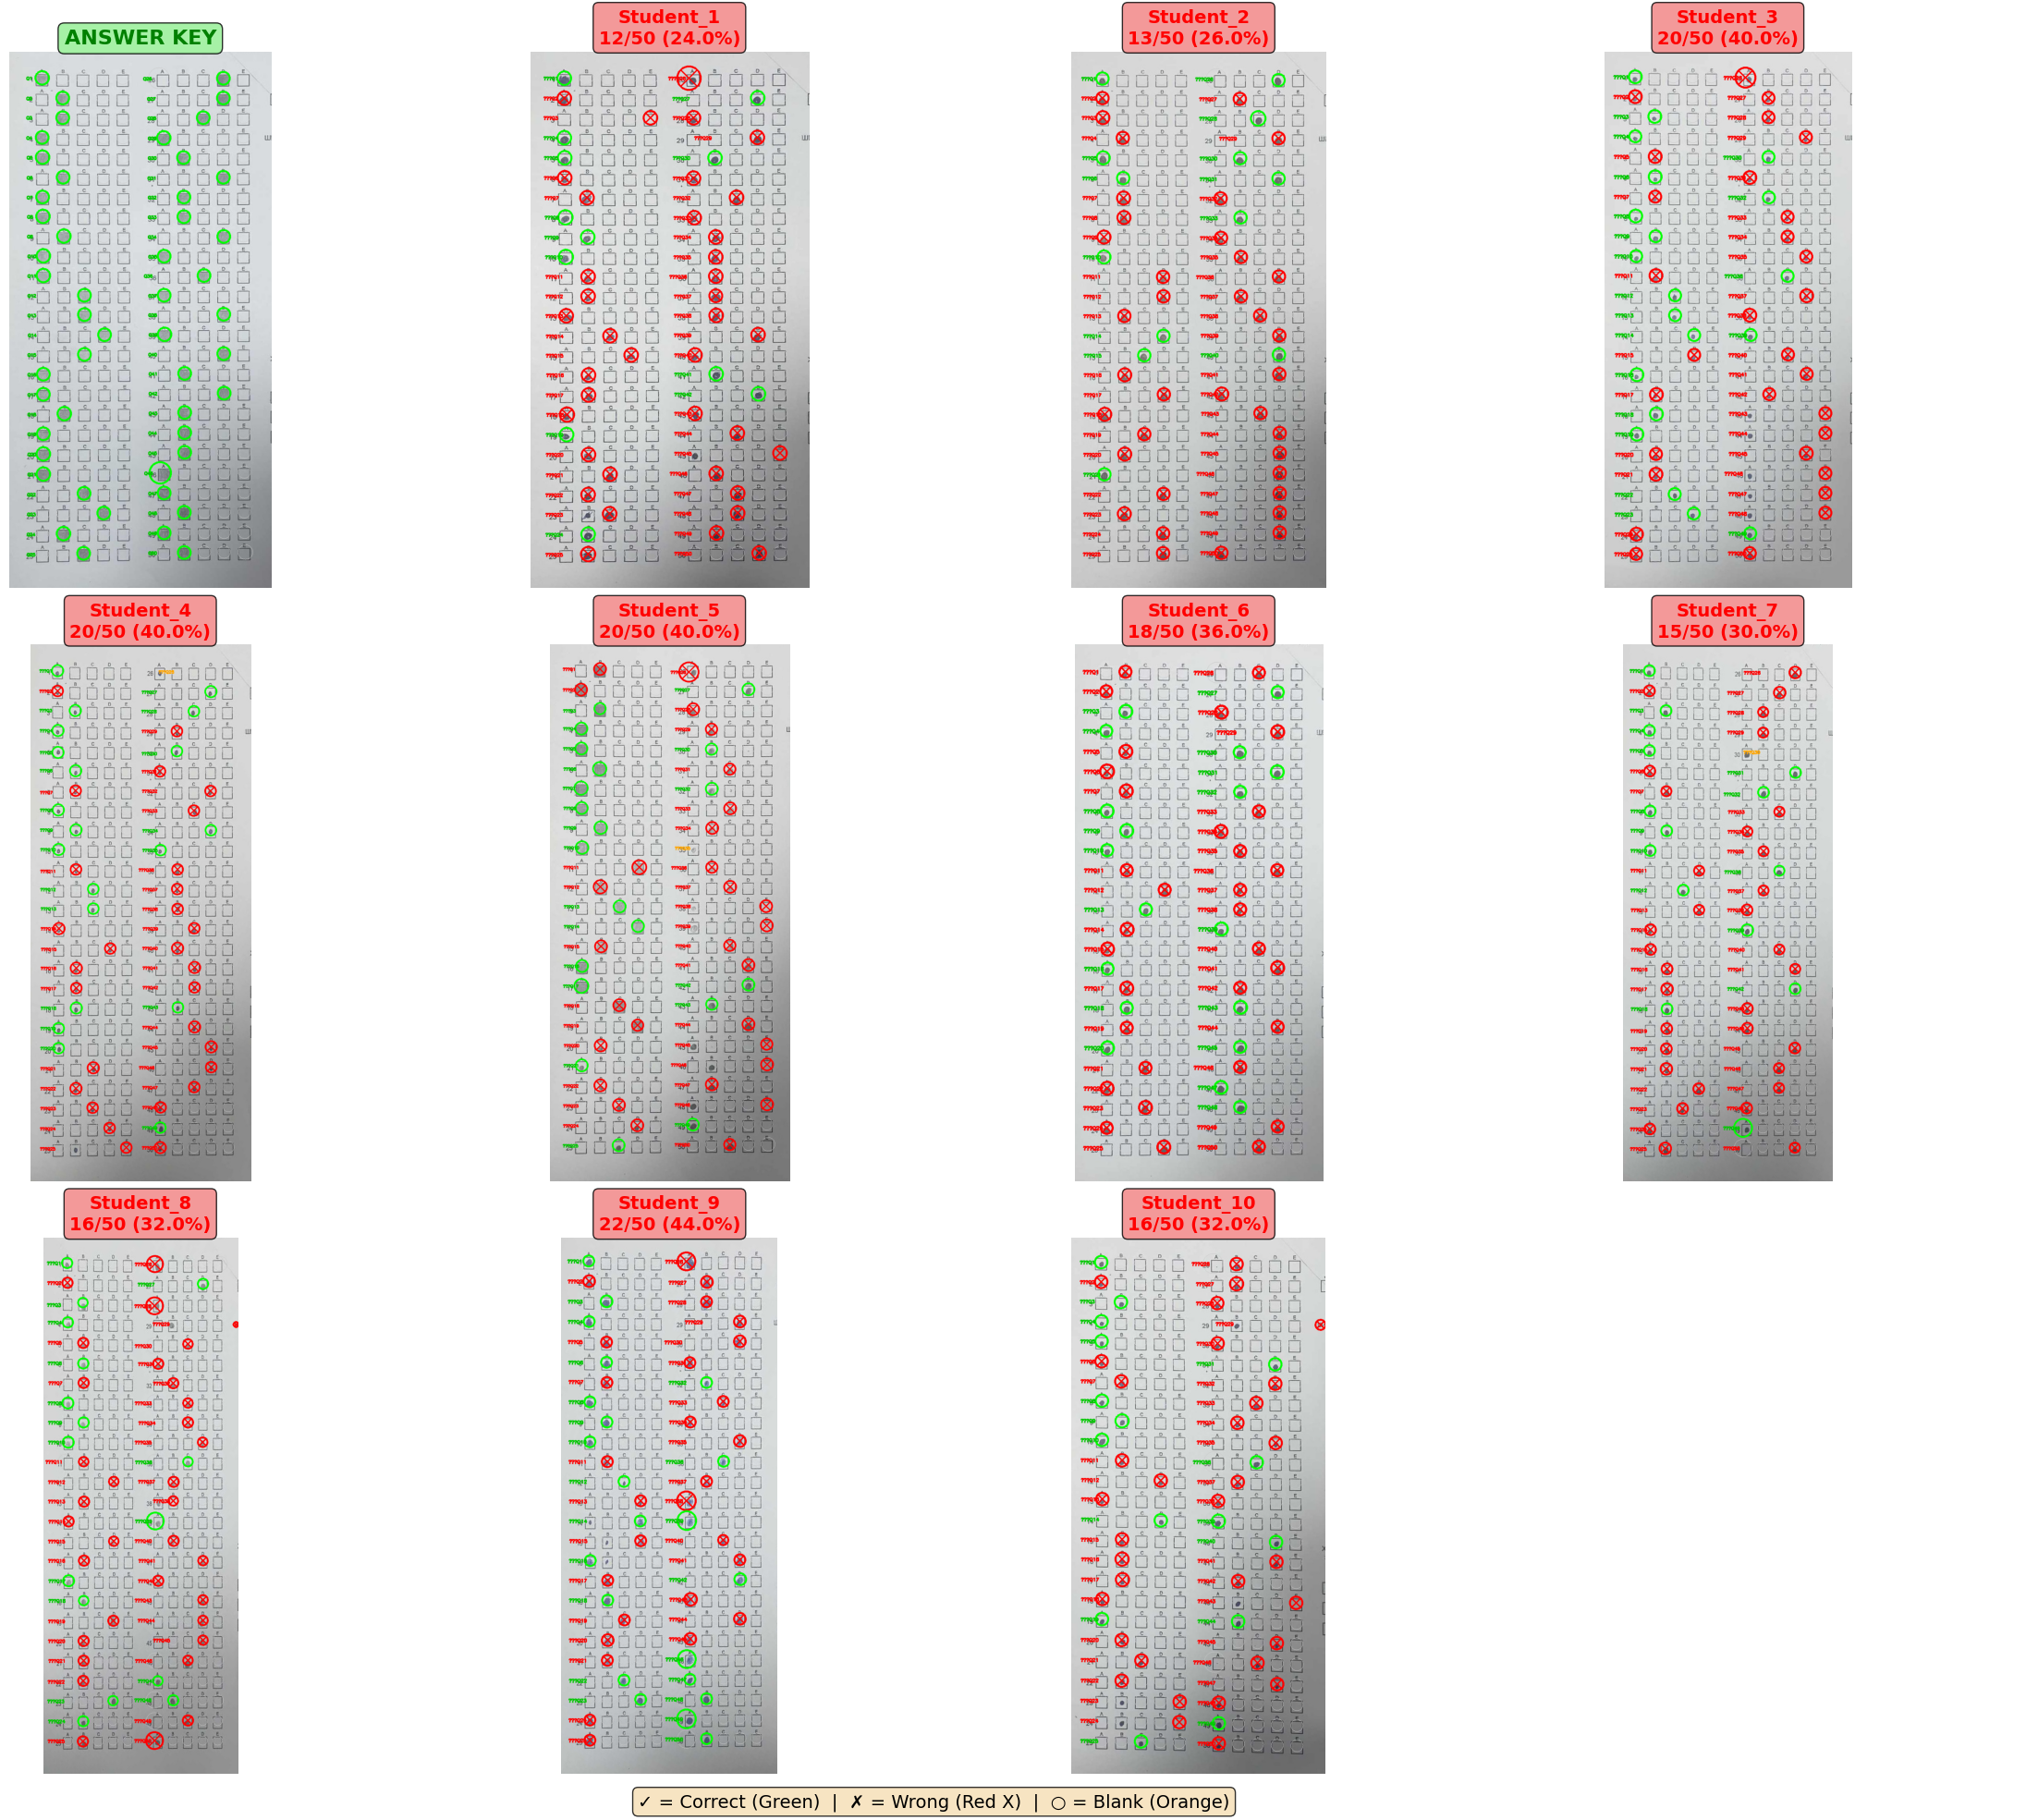


STEP 5: CREATING SUMMARY REPORTS
✓ Saved summary: omr_results/reports/OVERALL_SUMMARY.txt
✓ Saved JSON results: omr_results/reports/results.json

PROCESSING COMPLETE
Mode: BATCH
✓ Total students: 10
✓ Successfully graded: 10

Output folder: omr_results
  - Comparisons: omr_results/comparisons
  - Reports: omr_results/reports
  - Visualizations: omr_results/visualizations


✓ ALL PROCESSING COMPLETE!


In [ ]:
if __name__ == "__main__":

    input_dir = '.'
    output_dir = 'omr_results'
    input_folder = Path(input_dir)
    output_folder = Path(output_dir)
    output_folder.mkdir(parents=True, exist_ok=True)

    image_files = [f'{i}.jpg' for i in range(1, 12)]
    image_files.append('shablom.jpg')
    existing_files = []

    for img_file in image_files:
        try:
            test_img = cv2.imread(img_file)
            if test_img is not None:
                existing_files.append(img_file)
        except:
            pass

    if not existing_files:
        print("❌ No images found!")
        exit(1)

    print(f"✓ Found {len(existing_files)} images\n")

    corrected_images = {}
    for img_file in existing_files:
        try:
            print(f"\nProcessing: {img_file}")

            original, detected, edges, warped = detect_paper_ultra_robust(img_file)

            print(f"Checking orientation for {img_file}...")
            warped_corrected, was_rotated = correct_paper_orientation(warped)

            output_filename = f'corrected_{img_file}'
            cv2.imwrite(output_filename, warped_corrected)

            if was_rotated:
                print(f"✓ Saved (rotated 180°): {output_filename}")
            else:
                print(f"✓ Saved: {output_filename}")

            corrected_images[img_file] = warped_corrected

        except Exception as e:
            print(f"✗ Error processing {img_file}: {e}")

    print("\n" + "="*80)
    print(f"✓ STEP 1 COMPLETE: {len(corrected_images)}/{len(existing_files)} images corrected")
    print("="*80)

    print("\n" + "="*80)
    print("STEP 2: OMR PROCESSING")
    print("="*80)
    print("All images are now perspective-corrected AND properly oriented!")
    print("Proceeding with bubble detection and grading...\n")

    results = batch_process_omr_with_variants(
        input_folder='.',
        output_folder='omr_results',
        answer_key_filename='corrected_shablom.jpg'
    )

    print("\n" + "="*80)
    print("✓ ALL PROCESSING COMPLETE!")
    print("="*80)


OMR BATCH PROCESSING WITH VARIANT VALIDATION

STEP 1: PROCESSING ANSWER KEY
   Variant scores: ['210', '147', '208', '210', '210']
   Min: 147, Avg: 197, Contrast: 25.43%
   Variant B: intensity=147, contrast=25.43%, conf=0.98
✓ Answer Key Variant: B (confidence: 0.98)
   Total bubbles detected: 288
   Using Y-threshold: 29.6 pixels (avg bubble height: 39.4)
   Found 25 rows with bubbles
   Successfully organized 50/50 questions

   ⚠️  SUSPICIOUS DETECTIONS (very close intensities):
      Q49: Detected A, contrast=4.8, [A=131, B=158, C=150, D=142, E=136]
   ✓ Detected 50/50 answers
   ✓ Saved answer key: omr_results/reports/ANSWER_KEY.txt

STEP 2: DETERMINING FILES TO PROCESS
✓ Found 10 student exams to process

STEP 3: PROCESSING STUDENT EXAM(S)

────────────────────────────────────────────────────────────────────────────────
Processing: Student_1 (corrected_1.jpg)
────────────────────────────────────────────────────────────────────────────────
   Variant scores: ['201', '143', '195

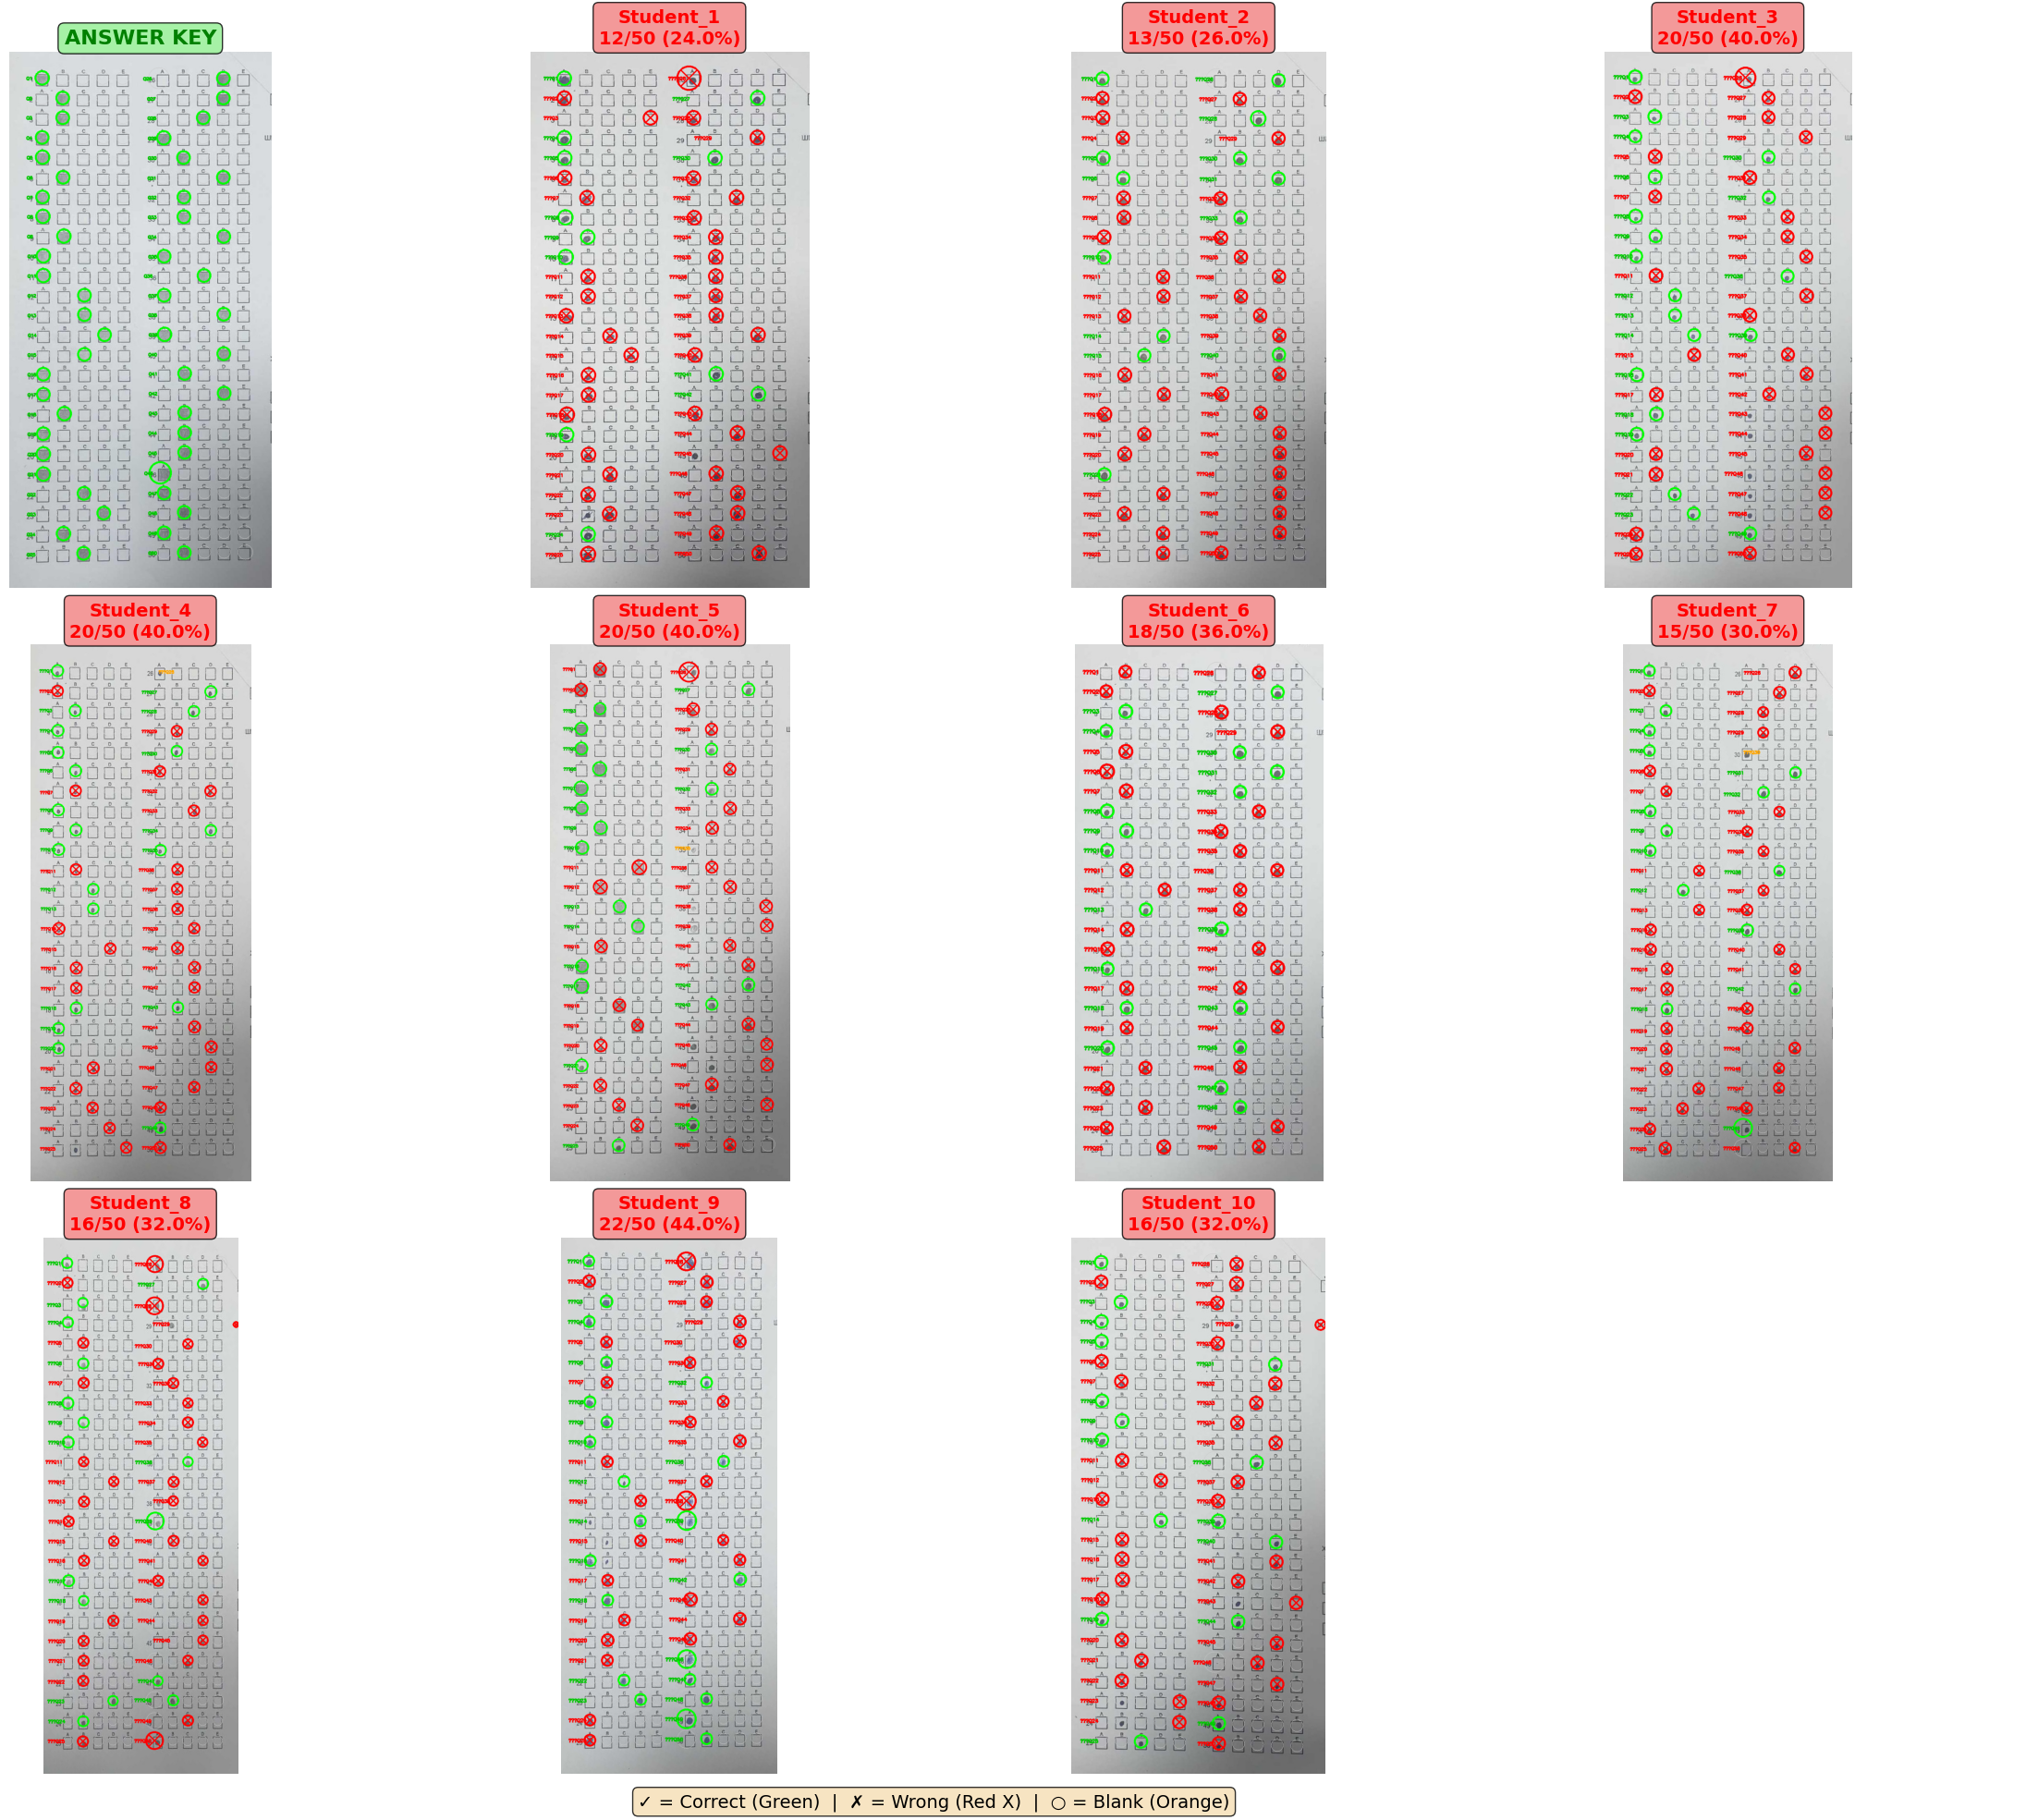


STEP 5: CREATING SUMMARY REPORTS
✓ Saved summary: omr_results/reports/OVERALL_SUMMARY.txt
✓ Saved JSON results: omr_results/reports/results.json

PROCESSING COMPLETE
Mode: BATCH
✓ Total students: 10
✓ Successfully graded: 10

Output folder: omr_results
  - Comparisons: omr_results/comparisons
  - Reports: omr_results/reports
  - Visualizations: omr_results/visualizations



In [ ]:
if __name__ == "__main__":
    results = batch_process_omr_with_variants(
        input_folder='.',
        output_folder='omr_results',
        answer_key_filename='corrected_shablom.jpg'
    )

Found 1 images to process


Processing: corrected_shablom.jpg
Image size: 1109x1513

⚠ No contour from combined edges, trying individual strategies...

❌ No 4-point contours found!
   Using largest contour bounding box...
✗ Error processing corrected_shablom.jpg: name 'cvcv2' is not defined



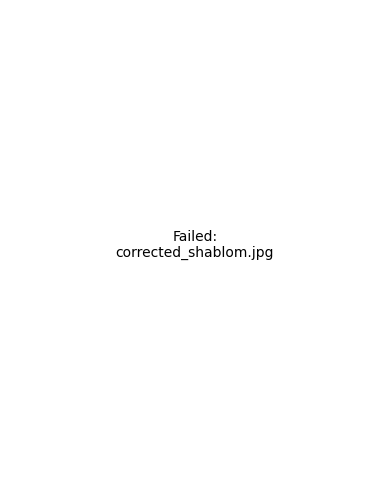

In [ ]:
if __name__ == "__main__":
    input='.'
    output='omr_results'
    input_folder = Path(input)
    output_folder = Path(output)
    output_folder.mkdir(parents=True, exist_ok=True)
    image_files = ['corrected_shablom.jpg']
    existing_files = []

    for img_file in image_files:
        try:
            test_img = cv2.imread(img_file)
            if test_img is not None:
                existing_files.append(img_file)
        except:
            pass

    if not existing_files:
        print("No images found! Please ensure images are named 1.jpg, 2.jpg, ..., 10.jpg, shablom.jpg")
    else:
        print(f"Found {len(existing_files)} images to process\n")

        n_images = len(existing_files)
        cols = min(5, n_images)
        rows = (n_images + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 5*rows))
        if n_images == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_images > 1 else [axes]

        for idx, img_file in enumerate(existing_files):
            try:
                original, detected, edges, warped = detect_paper_ultra_robust(img_file)

                output_filename = f'corrected_{img_file}'
                cv2.imwrite(output_filename, warped)
                print(f"✓ Saved: {output_filename}\n")

                warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
                axes[idx].imshow(warped_rgb)
                axes[idx].set_title(f'Corrected: {img_file}', fontsize=10)
                axes[idx].axis('off')

            except Exception as e:
                print(f"✗ Error processing {img_file}: {e}\n")
                axes[idx].text(0.5, 0.5, f'Failed:\n{img_file}',
                              ha='center', va='center', transform=axes[idx].transAxes)
                axes[idx].axis('off')

        for idx in range(len(existing_files), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig('all_corrected_documents.png', dpi=150, bbox_inches='tight')


OMR SINGLE IMAGE PROCESSING: corrected_shablom.jpg

STEP 1: PROCESSING ANSWER KEY
   Variant scores: ['210', '147', '208', '210', '210']
   Min: 147, Avg: 197, Contrast: 25.43%
   Variant B: intensity=147, contrast=25.43%, conf=0.98
✓ Answer Key Variant: B (confidence: 0.98)
   Total bubbles detected: 288
   Using Y-threshold: 29.6 pixels (avg bubble height: 39.4)
   Found 25 rows with bubbles
   Successfully organized 50/50 questions

   ⚠️  SUSPICIOUS DETECTIONS (very close intensities):
      Q49: Detected A, contrast=4.8, [A=131, B=158, C=150, D=142, E=136]
   ✓ Detected 50/50 answers
   ✓ Saved answer key: test/reports/ANSWER_KEY.txt

STEP 2: DETERMINING FILES TO PROCESS
✓ Processing single image: test (corrected_shablom.jpg)

STEP 3: PROCESSING STUDENT EXAM(S)

────────────────────────────────────────────────────────────────────────────────
Processing: test (corrected_shablom.jpg)
────────────────────────────────────────────────────────────────────────────────
   Variant scores:

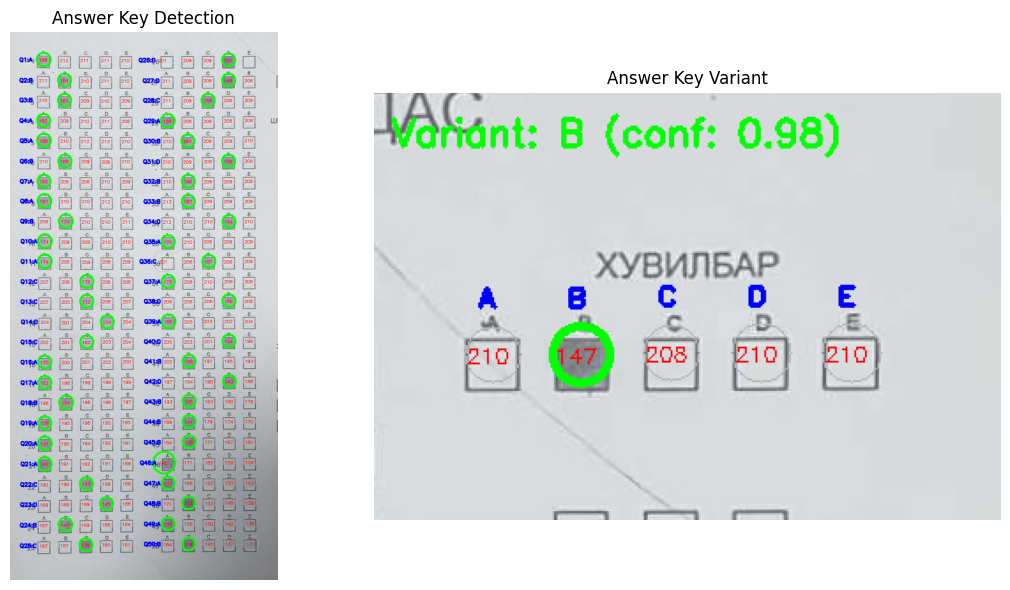

In [ ]:
if __name__ == "__main__":
    results = batch_process_omr_with_variants(
        input_folder='.',
        output_folder='test',
        answer_key_filename='corrected_shablom.jpg',
        single_image='corrected_shablom.jpg',
        student_name='test',
    )
    detection_image_path = '/content/test/visualizations/answer_key_detection.png'
    variant_image_path = '/content/test/comparisons/test_variant.png'

    detection_image = cv2.imread(detection_image_path)
    variant_image = cv2.imread(variant_image_path)

    detection_image_rgb = cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB)
    variant_image_rgb = cv2.cvtColor(variant_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(detection_image_rgb)
    plt.title('Answer Key Detection')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(variant_image_rgb)
    plt.title('Answer Key Variant')
    plt.axis('off')

    plt.tight_layout()
    plt.show()